In [1]:
!pip install bioinfokit

     |████████████████████████████████| 84 kB 1.1 MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.6-py3-none-any.whl size=57066 sha256=6140cfbba23a6d7a546a47a9f4ca0b337fa68ec12582dcc8c0ac29249ebe51d4
  Stored in directory: /root/.cache/pip/wheels/38/b2/a0/3f65c463d3faababa8cb5f3076e3bfc1c49fea2a736a49038a
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=702325d752289b4708b444089eb48b431bfd873409e38cad4c82a0dd02519350
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built bioinfokit adjustText


In [1]:
from sklearn import preprocessing, svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from bioinfokit.visuz import cluster
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import randint, loguniform

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('train.csv', index_col='ID')
df_train.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,y
ID,,,,,,,,,,,,,,,,,
0,58238,971.303,397.202654,186.945510,2.124697,0.882317,58977,272.306674,0.604756,0.987470,0.775723,0.685561,0.006820,0.000929,0.469994,0.998595,HOROZ
1,44515,757.601,265.590470,213.967453,1.241266,0.592420,44780,238.071960,0.771745,0.994082,0.974620,0.896387,0.005966,0.002376,0.803510,0.997370,SEKER
2,31662,653.783,239.902428,168.421505,1.424417,0.712136,32034,200.781748,0.801407,0.988387,0.930853,0.836931,0.007577,0.002293,0.700453,0.997737,DERMASON
3,38778,734.020,268.446281,184.061923,1.458456,0.727925,39208,222.201897,0.766137,0.989033,0.904439,0.827733,0.006923,0.002005,0.685142,0.999250,DERMASON
4,42530,775.403,281.212824,193.236878,1.455275,0.726511,43028,232.703412,0.729816,0.988426,0.888895,0.827499,0.006612,0.001912,0.684755,0.996507,SIRA


In [4]:
labels = df_train.y.unique()
labels

array(['HOROZ', 'SEKER', 'DERMASON', 'SIRA', 'BARBUNYA', 'CALI', 'BOMBAY'],
      dtype=object)

In [5]:
df_test = pd.read_csv('test.csv', index_col='ID')
df_test.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
ID,,,,,,,,,,,,,,,,
10834,57659,955.434,387.757607,196.625782,1.972059,0.861896,60188,270.949661,0.620790,0.957982,0.793735,0.698760,0.006725,0.000989,0.488266,0.962889
10835,28772,630.362,229.990785,159.609367,1.440960,0.719993,29127,191.399185,0.767458,0.987812,0.909913,0.832204,0.007994,0.002365,0.692563,0.997956
10836,54677,911.022,308.853903,226.398571,1.364204,0.680198,55858,263.850182,0.753013,0.978857,0.827860,0.854288,0.005649,0.001856,0.729808,0.995607
10837,24827,578.304,214.192699,147.788172,1.449322,0.723831,25121,177.794033,0.716508,0.988297,0.932871,0.830066,0.008627,0.002526,0.689009,0.998596
10838,141850,1432.847,524.923471,346.910920,1.513136,0.750492,143680,424.981211,0.804617,0.987263,0.868240,0.809606,0.003701,0.000981,0.655462,0.991803


In [14]:
X = df_train.drop("y", axis=1)
Y = df_train['y']



In [15]:
# Detect  outliers in the dataset

def outliers(df, features):
    outlier_indices = []

    for c in features:
        Q1 = np.percentile(df[c], 25)
        Q3 = np.percentile(df[c], 75)
        IQR = Q3 - Q1
        outlier_step = IQR * 1.5
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 1)

    return multiple_outliers

In [16]:
df_train = df_train.drop(outliers(df_train,['Area', 'Perimeter', 'MajorAxisLength',
                                                   'MinorAxisLength', 'AspectRation', 'Eccentricity',
                                                   'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity',
                                                   'roundness', 'Compactness', 'ShapeFactor1',
                                                   'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']), 
                         axis=0).reset_index(drop=True)

print('Number of of samples in the dataset after removing outliers: %d' % len(df_train))

Number of of samples in the dataset after removing outliers: 9333


In [17]:
# Convert Class String labels into Integers
lab_enc = preprocessing.LabelEncoder()
label_Y = lab_enc.fit_transform(Y)

# Normalize the input features of the dataset
normalizer = preprocessing.StandardScaler()
norm_X = normalizer.fit_transform(X)

In [18]:
# Normalize the Test features of the dataset
norm_X_test = normalizer.transform(df_test)

In [19]:
# Visualizing the Principal Components in the feature space

pca = PCA()
pca.fit(norm_X)
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC" + str(i) for i in list(range(1, num_pc + 1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X.columns.values
loadings_df = loadings_df.set_index('variable')

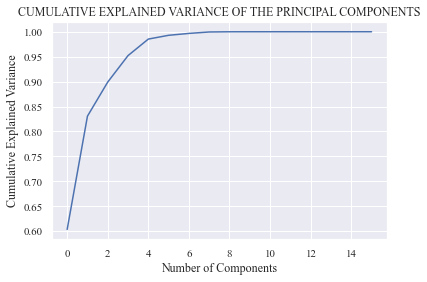

In [20]:
# Screeplot of Principal Components
cluster.screeplot(obj=[pc_list, pca.explained_variance_ratio_])

# 2D Bi-plot of Principal Components
pca_scores = PCA().fit_transform(norm_X)
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=X.columns.values, 
               var1=round(pca.explained_variance_ratio_[0]*100, 2),
               var2=round(pca.explained_variance_ratio_[1]*100, 2), 
               colorlist=Y)


# Cumulative Explained Variance Plot
plt.plot(np.cumsum(pca.explained_variance_ratio_)); 
plt.title('CUMULATIVE EXPLAINED VARIANCE OF THE PRINCIPAL COMPONENTS')
plt.xlabel('Number of Components'); 
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [41]:
from sklearn.metrics import confusion_matrix, classification_report



In [42]:
####################################################
################ MACHINE LEARNING ##################
####################################################

def training_model_metrics(model, X, Y):
    train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=12, shuffle=True)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    model_acc = metrics.accuracy_score(test_y, y_pred)
    f1_measure = metrics.f1_score(test_y, y_pred, average='macro')
    model_precision = metrics.precision_score(test_y, y_pred, average='macro')
    model_recall = metrics.recall_score(test_y, y_pred, average='macro')
    print('Accuracy: %.3f, f1 measure: %.3f, precision: %.3f, recall: %.3f' % (model_acc, f1_measure, model_precision, model_recall))
    #plot2(test_y, model.predict(test_x));
    plt.show()

In [43]:
def optimize_param(model, param, X_optim, Y_optim):
    rf_grid = RandomizedSearchCV(estimator=model, n_iter=30, param_distributions=param, scoring='f1_macro', n_jobs=-1,
                                 cv=5, verbose=2, random_state=12)
    print('Performance Metrics for ML Model of Dataset using optimized hyper-parameters')
    print('-----------------------------------------------------------------------')
    training_model_metrics(rf_grid, X_optim, Y_optim)
    print('The hyper-parameters with the best f1_macro performance:')
    print('----------------------------------------------------------')
    print(rf_grid.best_params_)

In [44]:
def evaluate_PC(model, user_input, user_output):
    train_x, test_x, train_y, test_y = train_test_split(user_input, user_output, test_size=0.2, random_state=12, shuffle=True)
    acc, comp = list(), list()

    for n in range(1, 16):
        pca = PCA(n_components=n)
        pca.fit(train_x)
        pca_transform = pca.fit_transform(train_x)
        cv = KFold(n_splits=5, shuffle=True, random_state=12)
        scores = cross_val_score(model, pca_transform, train_y, scoring='f1_macro', cv=cv, n_jobs=-1)
        acc.append(np.mean(scores))
        comp.append(n)
        print('> No of Components=%d, Accuracy=%.3f' % (n, np.mean(scores)))

    return acc, comp

In [45]:
def display_perf_plot(acc, comp):
    plt.plot(comp, acc)
    plt.title('PRINCIPAL COMPONENT ANALYSIS PERFORMANCE PLOT USING CROSS-VALIDATION')
    plt.axhline(y=max(acc), color='r', linestyle='--')
    plt.xlabel('NUMBER OF COMPONENTS')
    plt.ylabel('F1-MEASURE')
    plt.show()

In [46]:
def KFold_evaluation(model, X, Y):
    means, mins, maxs = list(), list(), list()
    folds = range(2, 13)
    for k in folds:
        cv = KFold(n_splits=k, shuffle=True, random_state=12)
        scores = cross_val_score(model, X, Y, scoring='f1_macro', cv=cv, n_jobs=-1)
        means.append(np.mean(scores))
        mins.append(np.mean(scores) - scores.min())
        maxs.append(scores.max() - np.mean(scores))
    plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    plt.title('CROSS-VALIDATION PERFORMANCE EVALUATION')
    plt.xlabel('NUMBER OF FOLDS')
    plt.ylabel('F1-MEASURE')
    plt.axhline(y=max(means), color='r', linestyle='--')
    plt.show()

In [47]:
####################################################
############ Random Forest Classification ##########
####################################################
print('******************RANDOM FOREST CLASSIFICATION MODEL**************************')
rf_model = RandomForestClassifier(random_state=12)

print('Performance metrics for Random Forest Classification of Original Data')
print('-----------------------------------------------------------------------')
print('Performance Metrics for ML Model of Dataset using default hyper-parameters')
print('-----------------------------------------------------------------------')
#print(norm_X.shape, label_Y.shape)
training_model_metrics(rf_model, norm_X, label_Y)

******************RANDOM FOREST CLASSIFICATION MODEL**************************
Performance metrics for Random Forest Classification of Original Data
-----------------------------------------------------------------------
Performance Metrics for ML Model of Dataset using default hyper-parameters
-----------------------------------------------------------------------
(9705, 16) (9705,)
Accuracy: 0.906, f1 measure: 0.912, precision: 0.917, recall: 0.909


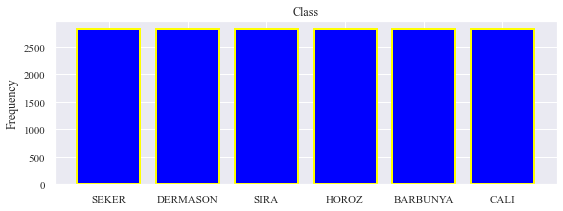

In [48]:
# Applying SMOTE technique on the dataset
sm = SMOTE(random_state=12)
X_sm, Y_sm = sm.fit_resample(norm_X, label_Y)

# Bar Chart to visualize the labels in the output variable in the SMOTE Balanced Dataset
Y_balanced = lab_enc.inverse_transform(Y_sm)
Y_balanced = pd.Index(Y_balanced, name='Class')
var = Y_balanced
varValue = var.value_counts()
plt.figure(figsize=(9, 3))
plt.bar(varValue.index, varValue,
        color= "blue", edgecolor="yellow",
        linewidth="2");plt.xticks(varValue.index,
                                  varValue.index.values)
plt.ylabel("Frequency")
plt.title('Class')
plt.show()

In [49]:
print('-----------------------------------------------------------------------')
print('Performance metrics for Random Forest Classification of SMOTE Balanced Data')
print('-----------------------------------------------------------------------')
print('Performance Metrics for ML Model of Dataset using default hyper-parameters')
print('-----------------------------------------------------------------------')
training_model_metrics(rf_model, X_sm, Y_sm)

-----------------------------------------------------------------------
Performance metrics for Random Forest Classification of SMOTE Balanced Data
-----------------------------------------------------------------------
Performance Metrics for ML Model of Dataset using default hyper-parameters
-----------------------------------------------------------------------
Accuracy: 0.952, f1 measure: 0.952, precision: 0.952, recall: 0.952


In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline_deep = Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler()),
                    ('pca', PCA(n_components=0.999))
                        ])

In [67]:
# PCA Dimensionality Reduction to 8 PCs
pca_rfsm = num_pipeline_deep.fit_transform(X_sm)
pca_test = num_pipeline_deep.transform(norm_X_test)
training_model_metrics(rf_model, pca_rfsm, Y_sm)

Accuracy: 0.952, f1 measure: 0.953, precision: 0.953, recall: 0.953


In [71]:
df_submit = pd.read_csv('sample_submission.csv', index_col='ID')
df_submit.head()
y_pred = rf_model.predict(pca_test)

y_test = lab_enc.inverse_transform(y_pred)
df_submit.y= y_test


In [73]:
df_submit.to_csv('aaaaaaaaaaaaa00.csv')

In [53]:

### Tensorflow and Keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

In [54]:
X_train.shape

(13531, 8)

In [55]:
### Building the Model

model = Sequential()
model.add(Dense(512, activation='tanh', input_shape=(8,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

In [56]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

early_stopp = EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss')

history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_val, y_val), 
                    batch_size=32)

Epoch 1/100
423/423 [==============================] - 5s 9ms/step - loss: 0.6406 - accuracy: 0.8229 - val_loss: 0.3037 - val_accuracy: 0.9161
Epoch 2/100
423/423 [==============================] - 4s 9ms/step - loss: 0.3554 - accuracy: 0.9002 - val_loss: 0.2371 - val_accuracy: 0.9249
Epoch 3/100
423/423 [==============================] - 4s 9ms/step - loss: 0.2959 - accuracy: 0.9096 - val_loss: 0.2158 - val_accuracy: 0.9285
Epoch 4/100
423/423 [==============================] - 3s 8ms/step - loss: 0.2705 - accuracy: 0.9161 - val_loss: 0.2160 - val_accuracy: 0.9261
Epoch 5/100
423/423 [==============================] - 3s 7ms/step - loss: 0.2613 - accuracy: 0.9175 - val_loss: 0.2029 - val_accuracy: 0.9320
Epoch 6/100
423/423 [==============================] - 3s 7ms/step - loss: 0.2514 - accuracy: 0.9203 - val_loss: 0.2111 - val_accuracy: 0.9288
Epoch 7/100
423/423 [==============================] - 3s 7ms/step - loss: 0.2510 - accuracy: 0.9195 - val_loss: 0.2003 - val_accuracy: 0.9308

Epoch 58/100
423/423 [==============================] - 2s 6ms/step - loss: 0.2011 - accuracy: 0.9320 - val_loss: 0.1733 - val_accuracy: 0.9406
Epoch 59/100
423/423 [==============================] - 2s 6ms/step - loss: 0.2051 - accuracy: 0.9319 - val_loss: 0.1715 - val_accuracy: 0.9397
Epoch 60/100
423/423 [==============================] - 2s 6ms/step - loss: 0.2009 - accuracy: 0.9342 - val_loss: 0.1691 - val_accuracy: 0.9409
Epoch 61/100
423/423 [==============================] - 2s 6ms/step - loss: 0.2019 - accuracy: 0.9347 - val_loss: 0.1702 - val_accuracy: 0.9406
Epoch 62/100
423/423 [==============================] - 2s 6ms/step - loss: 0.2028 - accuracy: 0.9305 - val_loss: 0.1745 - val_accuracy: 0.9379
Epoch 63/100
423/423 [==============================] - 2s 6ms/step - loss: 0.2014 - accuracy: 0.9356 - val_loss: 0.1724 - val_accuracy: 0.9400
Epoch 64/100
423/423 [==============================] - 2s 6ms/step - loss: 0.2033 - accuracy: 0.9306 - val_loss: 0.1756 - val_accuracy:

In [58]:
model.evaluate(X_val, y_val)

106/106 [==============================] - 0s 2ms/step - loss: 0.1597 - accuracy: 0.9435


[0.15974922478199005, 0.9435412287712097]

In [59]:
### extract results from history

train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss)+1)

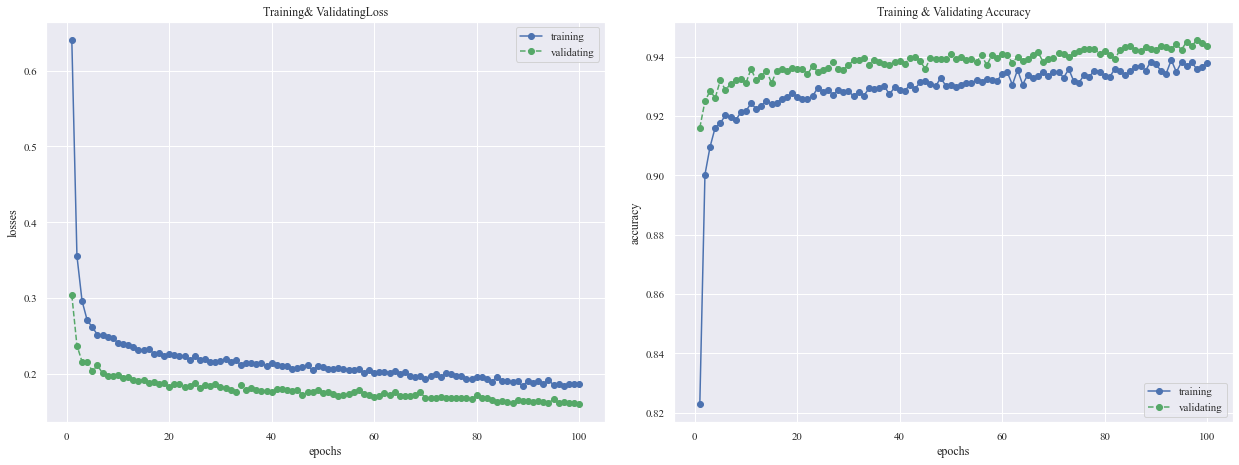

In [60]:
### get some results and Visualization from history
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
fig.tight_layout(pad=4)  ## to avoid overlaping of titles in subplots (try comment it you will know)

plt.sca(ax[0])
plt.plot(epochs, train_loss, 'bo-', label='training')
plt.plot(epochs, val_loss, 'go--', label='validating')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.title('Training& ValidatingLoss')
plt.legend()

plt.sca(ax[1])
plt.plot(epochs, train_acc, 'bo-', label='training')
plt.plot(epochs, val_acc, 'go--', label='validating')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training & Validating Accuracy')

plt.legend(loc='lower right')
plt.show()

In [61]:
from sklearn.metrics import f1_score

nums_predictions = np.argmax(model.predict(X_val), axis=-1)
print(" ====> ",f1_score(nums_predictions, y_val,average="micro"))

106/106 [==============================] - 0s 2ms/step
 ====>  0.9435412355897133


In [62]:
y_pred = np.argmax(model.predict(pca_test), axis=-1)
y_test = lab_enc.inverse_transform(y_pred)

85/85 [==============================] - 0s 2ms/step


In [63]:
df_submit = pd.read_csv('sample_submission.csv', index_col='ID')
df_submit.head()

,y
ID,
10834,HOROZ
10835,HOROZ
10836,HOROZ
10837,HOROZ
10838,HOROZ


In [64]:
df_submit.y = y_test

In [65]:
df_submit.head()

,y
ID,
10834,HOROZ
10835,DERMASON
10836,BARBUNYA
10837,DERMASON
10838,CALI


In [66]:
df_submit.to_csv('aaaaaaaaaaaaa.csv')